In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('ggplot')
import sys
import numerical_sim.LIF_ntwk_current_based_delta_synapses as sim
from graphs.my_graph import set_plot, put_list_of_figs_to_svg_fig

In [20]:
## ==========================================
## initializing network model parameters
## ==========================================
# -------- everything in SI units -----------

# excitatory cell 
Ecell_params = {'Tm':15e-3, 'Vthre':15e-3, 'Vreset':4e-3, 'Trefrac': dt, 'label':'Ecort'}
# inhibitory cell 
Icell_params = {'Tm':15e-3, 'Vthre':10e-3, 'Vreset':4e-3, 'Trefrac': dt, 'label':'Icort'}

# synaptic weights
Qe, Qi = .5e-3, -.5e-3
syn_params = {
             'J_Eaff_Ecort':Qe, 'J_Eaff_Icort':Qe,
             'J_Idsinh_Icort':Qi,
             'J_Ecort_Ecort':Qe,'J_Ecort_Icort':Qe,
             'J_Icort_Ecort':Qi,'J_Icort_Icort':Qi,
              }
# network and connectivity parameters
ntwk_params = {
              'N_Ecort':4000, 'N_Icort':1000,
              'N_Eaff':400, 'N_Idsinh':100,
              'p_Eaff_Ecort':0.5, 'p_Eaff_Icort':0.5,
              'p_Idsinh_Icort':0.5,
              'p_Ecort_Ecort':0.05,'p_Ecort_Icort':0.05,
              'p_Icort_Ecort':0.05,'p_Icort_Icort':0.05
              }
# afferent activity parameters
drive_params = {'F_Eaff':0., 'F_Idsinh':0.}

In [21]:
# ============================================
#    Numerical sim: a single trial example 
# ============================================
fe, fi = 3., 10.
dt = 5e-5
vv, fout = sim.run_sim(Ecell_params, Icell_params, ntwk_params,\
                       syn_params, drive_params,
                       experiment={'type':'single-cell-exc', 'fe':fe, 'fi':fi},
                       tstop=5., dt=dt)

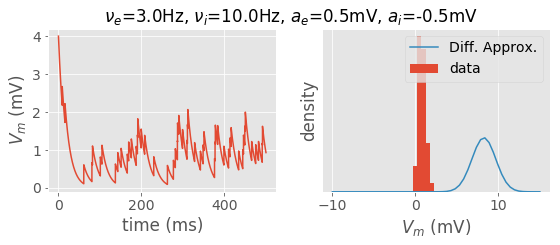

In [19]:
# plotting
fig, AX = plt.subplots(1, 2, figsize=(9,3))
fig.suptitle('$\\nu_e$='+str(fe)+'Hz, $\\nu_i$='+str(fi)+'Hz, $a_e$='+str(1e3*Qe)+'mV, $a_i$='+str(1e3*Qi)+'mV')
v = np.linspace(-10, 15) # for histogram
t = np.arange(len(vv[0]))*dt
AX[0].plot(1e3*t[t<.5], 1e3*vv[0][t<.5])
AX[1].hist(1e3*vv[0], bins=v, normed=True, label='data')
AX[0].set_ylabel(r'$V_m$ (mV)');AX[0].set_xlabel('time (ms)')
AX[1].set_xlabel(r'$V_m$ (mV)');AX[1].set_ylabel('density')
AX[1].set_yticks([]);
params = concat_params(fe, fi, Ecell_params, ntwk_params, syn_params, drive_params)
Fout, Distrib = Gaussian_Approx(params, v=1e-3*v)
AX[1].plot(v, Distrib/np.trapz(Distrib,v), label='Diff. Approx.')
AX[1].legend();
fig.savefig('/Users/yzerlaut/Desktop/fig.png')

In [17]:
# ================================================
#   A set of conditions for comparison with theory
# ================================================

fe = np.linspace(0., 5., 10)
Fout_sim = [sim.run_sim(Ecell_params, Icell_params, ntwk_params, syn_params,\
            {'F_Eaff':0., 'F_Idsinh':0.}, dt=1e-5, tstop=1.,
            experiment={'type':'single-cell-exc', 'fe':ff, 'fi':3.})[1] for ff in fe]

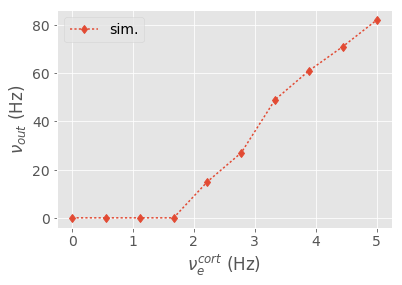

In [24]:
# plotting
plt.plot(fe, Fout_sim, 'd:', label='sim.')
plt.ylabel(r'$\nu_{out}$ (Hz)');plt.xlabel(r'$\nu_e^{cort}$ (Hz)')
plt.legend();

In [17]:
def concat_params(fe, fi, cell_params, ntwk_params, syn_params, drive_params):
    freqs = {'fe':fe, 'fi':fi}
    return dict(cell_params.items()|ntwk_params.items()|syn_params.items()|drive_params.items()|freqs.items())

def get_shotnoise_params(params):
    # integrative properties
    Tm, Vthre, Vreset = params['Tm'], params['Vthre'], params['Vreset']
    # synaptic weights
    Je, Ji = params['J_Ecort_'+params['label']], params['J_Icort_'+params['label']]
    # number of synapses
    Ne = params['N_Ecort']*params['p_Ecort_'+params['label']]
    Ni = params['N_Icort']*params['p_Icort_'+params['label']]
    Fe, Fi = Ne*params['fe'], Ni*params['fi']
    return Je, Ji, Fe, Fi, Tm, Vthre, Vreset

import scipy.integrate as sp_int
import scipy.special as sp_spec
def Psi(Array):
    return np.exp(Array*Array)*(sp_spec.erf(Array)+1)

def Vm_statistics(Je, Ji, Fe, Fi, Tm):
    Ie, Ii = Fe*Tm*Je, Fi*Tm*Ji
    sIe, sIi = Je*np.sqrt(Fe*Tm/2.), Ji*np.sqrt(Fi*Tm/2.)
    # mean and variance of membrane pot
    muV, sV = Ie-Ii, np.sqrt(sIe**2+sIi**2)
    return muV, sV
    
## First passage time see. e.g. Brunel & Hakim, 1998
def FPT_diffusion_approx(Je, Ji, Fe, Fi, Tm, Vthre, Vreset):
    # mean and variance of synaptic currents
    muV, sV = Vm_statistics(Je, Ji, Fe, Fi, Tm)
    x1=(Vreset-muV)/np.sqrt(2)/sV
    x2=(Vthre-muV)/np.sqrt(2)/sV
    integral = sp_int.quad(Psi,x1,x2)
    if integral[0]<float('inf') and integral[0]>0:
        T=Tm*np.sqrt(np.pi)*integral[0]
        freq=1.0/T
    else:
        freq=1e-9 # arbitrary for "negligible"
    return freq
    
def Proba_distrib_diffusion_approx(v, Je, Ji, Fe, Fi, Tm, Vthre, Vreset):
    muV, sV = Vm_statistics(Je, Ji, Fe, Fi, Tm)
    def rescale(vvv):
        return (vvv-muV)/np.sqrt(2)/sV
    def exp_square(y):
        return np.exp(y**2)
    nu_out = FPT_diffusion_approx(Je, Ji, Fe, Fi, Tm, Vthre, Vreset)
    integral = sp_int.quad(exp_square, rescale(max([v, Vreset])), rescale(Vthre))
    return np.sqrt(2)*nu_out/sV*np.exp(-rescale(v)**2)*integral[0]

def Gaussian_Approx(params, v=None):
    nu_out = FPT_diffusion_approx(*get_shotnoise_params(params))
    P = [Proba_distrib_diffusion_approx(vv, *get_shotnoise_params(params)) for vv in v]
    return nu_out, P/np.trapz(P, v) 

In [6]:
# ======================================
#       Building up the theory
# ======================================

def TF(fe, fi, cell_params, ntwk_params, syn_params, drive_params,
       with_proba_fig=False, nrun_max=2, discret = int(1e3), dt = 1e-9):
    params = concat_params(fe, fi, cell_params, ntwk_params, syn_params, drive_params)
    return FPT_shotnoise(params, with_fig=with_proba_fig, nrun_max=nrun_max, discret = discret, dt = dt)

def fluxes_from_proba(F, v, P, Fout, Tm, Vreset, Fe, Fi, j_m_iJe_bounded, j_m_iJi_bounded):
    Ji0_LB = Tm*P[0]/v[0]
    print(Ji0_LB)
    F[0] = Fout*np.array([0 if vv<Vreset else 1 for vv in v])
    for j in range(len(v)):
        F[1][j] = Fe*np.trapz(P[j_m_iJe_bounded(j):j], v[j_m_iJe_bounded(j):j])
        F[2][j] = Fi*np.trapz(P[j:j_m_iJi_bounded(j)], -v[j:j_m_iJi_bounded(j)]) # need to reverse signs
    F[1][v>Vreset] += Fout
    F[2] += Ji0_LB
    return F

def FPT_shotnoise(params, with_fig=False, nrun_max=2, discret = int(1e3), dt = 1e-9):

    Je, Ji, Fe, Fi, Tm, Vthre, Vreset = get_shotnoise_params(params)
    
    # lower bound =-Vthre for convenience
    v = np.linspace(-Vthre, Vthre, int(2*discret))
    dv = v[1]-v[0]

    # initialize probability and firing rate to diffusion approximation
    Fout, P = Gaussian_Approx(params, v=v)
    
    iJe, iJi = int(Je/dv), int(Ji/dv) # integers corresponding to synaptic weights
    def j_m_iJe_bounded(j): # j-iJe
        # when v<Vlb, proba=0, i.e. =Pr(V=Vlb)
        return max([0, j-iJe]) 
    def j_m_iJi_bounded(j): # j-iJi
        # when v>Vthre, proba=0, i.e. =Pr(V=Vthre)
        return min([j-iJi, 2*discret-1]) 

    Nsyn = 2 # excitation and inhibition to start
    F = [0*v for k in range(Nsyn+1)] # will represent the dimensionless fluxes (before boundary constraints)
    F = fluxes_from_proba(F, v, P, Fout, Tm, Vreset, Fe, Fi, j_m_iJe_bounded, j_m_iJi_bounded)

    C = integrate.cumtrapz(P, v)
    
    ## =======================
    # starting iterative loop
    nrun = 0
    while nrun<nrun_max: # insuring not too many runs
        nrun +=1 
        if with_fig:
            plt.plot(1e3*v, P)
            # plt.plot(1e3*v[:-1], C)
            # plt.plot(1e3*v, F[1], label='Je')
            # plt.plot(1e3*v, (F[0]-F[1]-v*P/Tm), label='Ji')
            # plt.plot(1e3*v, F[2], label='J')
        # backward integration from threshold
        dPdv = np.diff(P)/dv # numerical derivative
        DP = 0.*v[1:]
        DC = 0.*v[1:]
        for j in np.arange(len(v)-1):
            DC[j] = dt*(-v[j]*P[j]/Tm+Fe*(P[j]-P[j_m_iJe_bounded(j)])+Fi*(P[j]-P[j_m_iJi_bounded(j)]))
        for j in np.arange(len(v)-1):
            DP[j] = dt*(-(v[j]*dPdv[j]+P[j])/Tm+Fe*(P[j]-P[j_m_iJe_bounded(j)])+Fi*(P[j]-P[j_m_iJi_bounded(j)]))
        # for j in np.arange(2*discret-2, discret, -1):
        #     DP[j] += dt*(-P[j]/Tm-v[j]*dPdv[j-1]/Tm-Fe*(P[j]-P[j_m_iJe_bounded(j)])-Fi*(P[j]-P[j_m_iJi_bounded(j)]))
        #     F[1][j-1] = F[1][j]-dv*Fe*(P[j]-P[j-iJe])
        #     F[2][j-1] = F[2][j]-dv*Fi*(P[j]-P[j_m_iJi_bounded(j)])
        # # upward integration from lower bound
        # for j in np.arange(0, discret-1):
        #     DP[j] += dt*(-P[j]/Tm-v[j]*dPdv[j]/Tm-Fe*(P[j]-P[j_m_iJe_bounded(j)])-Fi*(P[j]-P[j_m_iJi_bounded(j)]))
        #     F[1][j+1] = F[1][j]+dv*Fe*(P[j]-P[j_m_iJe_bounded(j)])
        #     F[2][j+1] = F[2][j]+dv*Fi*(P[j]-P[j-iJi])
        # alpha = F[1][discret]/F[1][discret-1]
        # for k in range(Nsyn+1):
        #     F[k][:discret] = alpha*F[k][:discret] # first constraint
        # F[2] = (F[0]-F[1]-v*P/Tm)
        # F[1] += dv*Fe*(P-P[[j_m_iJe_bounded(jj) for jj in np.arange(len(v))]])
        # F[2] += dv*Fi*(P-P[[j_m_iJi_bounded(jj) for jj in np.arange(len(v))]])
        # P = (F[1]+F[2]-F[0])*Tm/v
        # P[:discret] = P[discret]/P[discret-1]*P[:discret] # first constraint
        # DC[:discret] = integrate.cumtrapz(DP[:discret], v[:discret])
        # DC[discret:] = integrate.cumtrapz(DP[::-1][discret:], v[::-1][discret:])
        # P[1:] += DP
        C += DC
        C[discret:] /= C[-1]
        P = np.concatenate([[0], np.diff(C)/dv, [0]])
        Fout = (Tm*np.trapz(P,v))**(-1) # Fout from second constraint
        
    # if with_fig:
        plt.xlabel(' Vm (mV)')
        plt.ylabel('proba. density')
        # plt.legend(loc='upper left', prop={'size':'small'});
    return Fout
                
TF(1., 1., Ecell_params, ntwk_params, syn_params, drive_params, with_proba_fig=True, nrun_max=3, discret = int(1e3), dt = 1e-6)

NameError: name 'integrate' is not defined

-3.54581749375e-13


-0.0333500083375 0.0333500083375 1.00024870416 0.999751371081


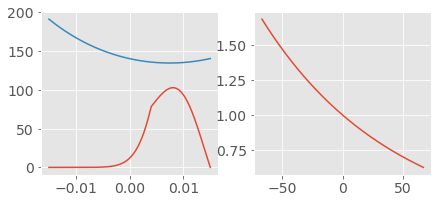

In [303]:
##############################################################################
#### Looking at Laplace transform
##############################################################################
from scipy import integrate

def Laplace(fe, fi, cell_params, ntwk_params, syn_params, drive_params, with_proba_fig=False, nrun_max=2, discret=int(1e3)):
    params = concat_params(cell_params, ntwk_params, syn_params, drive_params)
    # integrative properties
    Tm, Vthre, Vreset = params['Tm'], params['Vthre'], params['Vreset']
    # synaptic weights
    Je, Ji = params['J_Ecort_'+params['label']], params['J_Icort_'+params['label']]
    # number of synapses
    Ne = params['N_Ecort']*params['p_Ecort_'+params['label']]
    Ni = params['N_Icort']*params['p_Icort_'+params['label']]
    Fe, Fi = Ne*fe, Ni*fi

    # lower bound =-Vthre for convenience
    v = np.linspace(-Vthre, Vthre, int(2*discret))
    dv = v[1]-v[0]

    # initialize probability and firing rate to diffusion approximation
    Fout, P = Gaussian_Approx(v, Je, Ji, Fe, Fi, Tm, Vthre, Vreset)
    
    s = np.linspace(-1./Vthre, 1./Vthre, len(v))
    # s = np.linspace(-1e3, 1e3, len(v))

    fig, AX = plt.subplots(1, 2, figsize=(7,3))
    P_laplace = [np.trapz(np.exp(-ss*v)*P, v) for ss in s]
    print(s[discret-1], s[discret], P_laplace[discret-1], P_laplace[discret])
    AX[0].plot(v, P)
    AX[1].plot(s, P_laplace)
    P_inv = [np.trapz(np.exp(s*vv)*P_laplace, s) for vv in v]
    AX[0].plot(v, P_inv)

Laplace(1., 1., Ecell_params, ntwk_params, syn_params, drive_params, with_proba_fig=True, nrun_max=1)


In [39]:
## ===>. Running Network Simulation

bs_data = sim.run_sim(Ecell_params, Icell_params, ntwk_params,\
                       syn_params, drive_params,
                       synaptic_distrib='',
                       experiment={'type':'recurrent-network'}, tstop=.3, nrec=3)


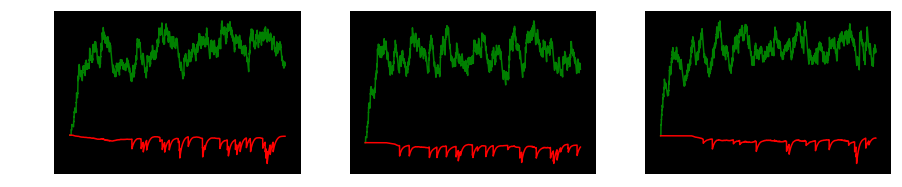

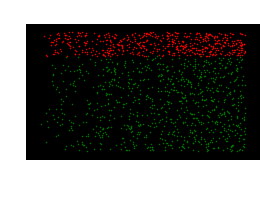

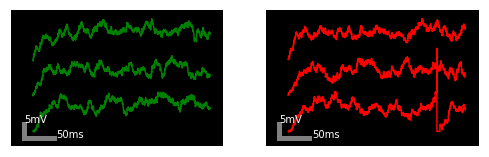

0.71 1.78


In [122]:
## ===>. Analyzing Simulation

sim.analyze_ntwk_sim(bs_data)
print(bs_data['mean_exc_rate'], bs_data['mean_inh_rate'])
FIGS = sim.plot_ntwk_sim(bs_data)
put_list_of_figs_to_svg_fig(FIGS, fig_name='fig_bs.svg')

In [43]:
##############################################################################
#### The Sparse Activity State
##############################################################################

# excitatory cell 
Ecell_params = {'Tm':15e-3, 'Vthre':15e-3, 'Vreset':4e-3, 'Trefrac': 5e-3}
# inhibitory cell 
Icell_params = {'Tm':15e-3, 'Vthre':13e-3, 'Vreset':4e-3, 'Trefrac': 5e-3}
# synaptic weights
Qe, Qi = 2e-3, -2e-3/5.
syn_params = {
             'J_Eaff_Ecort':Qe, 'J_Eaff_Icort':Qe,
             'J_Idsinh_Icort':Qi,
             'J_Ecort_Ecort':Qe/10.,'J_Ecort_Icort':Qe/10.,
             'J_Icort_Ecort':Qi,'J_Icort_Icort':Qi,
              }
# network and connectivity parameters
ntwk_params = {
              'N_Ecort':4000, 'N_Icort':1000,
              'N_Eaff':400, 'N_Idsinh':100,
              'p_Eaff_Ecort':0.5, 'p_Eaff_Icort':0.5,
              'p_Idsinh_Icort':0.5,
              'p_Ecort_Ecort':0.05,'p_Ecort_Icort':0.05,
              'p_Icort_Ecort':0.05,'p_Icort_Icort':0.05
              }
# afferent activity parameters
drive_params = {'F_Eaff':0.55, 'F_Idsinh':0.}

sas_data = sim.run_sim(Ecell_params, Icell_params, ntwk_params,\
                       syn_params, drive_params,
                       experiment={'type':'recurrent-network'}, tstop=.3, nrec=3)

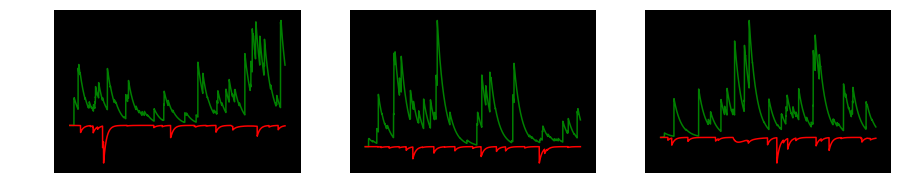

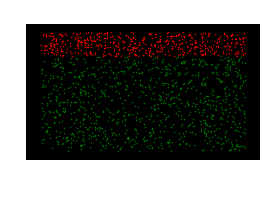

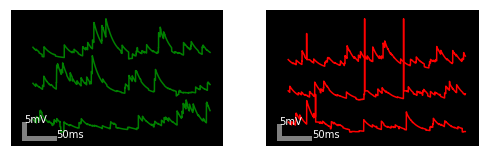

In [121]:
sim.analyze_ntwk_sim(sas_data)
FIGS = sim.plot_ntwk_sim(sas_data)
put_list_of_figs_to_svg_fig(FIGS, fig_name='fig_sas.svg')

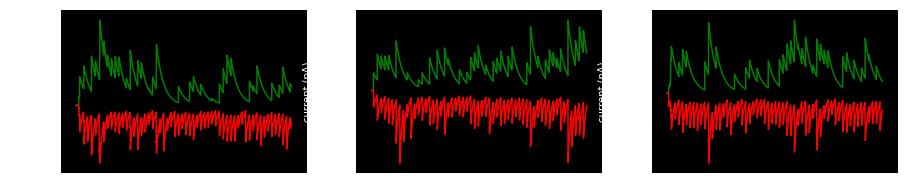

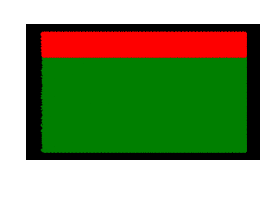

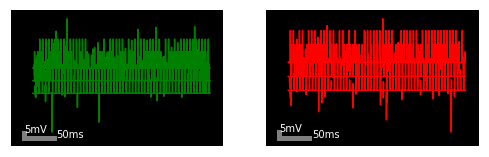

In [120]:
sas2_data = sim.run_sim(Ecell_params, Icell_params, ntwk_params,\
                       syn_params, {'F_Eaff':0.8, 'F_Idsinh':0.},
                       experiment={'type':'recurrent-network'}, tstop=.3, nrec=3)
sim.analyze_ntwk_sim(sas2_data)
FIGS = sim.plot_ntwk_sim(sas2_data)
put_list_of_figs_to_svg_fig(FIGS, fig_name='fig_sas2.svg')

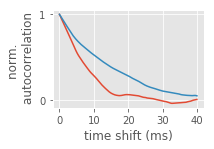

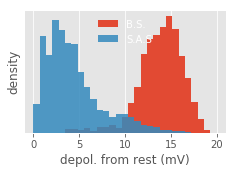

In [119]:
"""
We compare two regimes
"""
from analysis.compare_two_regimes import Vm_hist, Vm_Tv
import brian2

fig1 = Vm_hist(bs_data, sas_data, LABELS=['B.S.', 'S.A.S'])
fig2 = Vm_Tv(bs_data, sas_data, LABELS=['B.S.', 'S.A.S'], tstop=40)
fig1.savefig('vm_hist_comp.svg')    
fig2.savefig('vm_TV_comp.svg')    

In [0]:
# then fake data at the moment for illustration purpose
with plt.style.context(('ggplot')):
     fig, ax = plt.subplots(figsize=(3,2.))
     plt.subplots_adjust(bottom=.2, left=.2)
     ax.set_ylabel('firing rate (Hz)')
     ax.bar([1, 2.5], [1, 1.8], width=.5)
     ax.bar([0.5, 2], [.5, .9], width=.5)
     # ax.set_yticks([0,75,150])
     ax.set_xticks([0.75,2.25])
     ax.set_xticklabels(['exc.', 'inh.'])
     ax.set_yticks([0,1,2])
     ax.set_yticklabels(['0.1', '1', '10'])
fig.savefig('balance.svg')
     


NameError: name 'data' is not defined

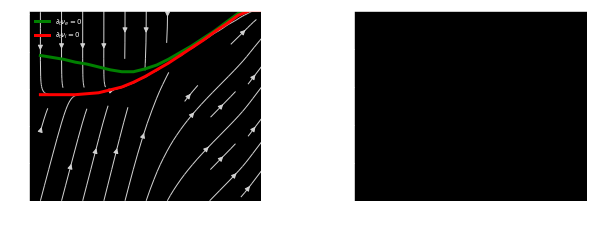

NameError: name 'data' is not defined

In [89]:
##############################################################################
#### Something Else ?
##############################################################################

# excitatory cell 
Ecell_params = {'Tm':15e-3, 'Vthre':15e-3, 'Vreset':4e-3, 'Trefrac': 5e-3}
# inhibitory cell 
Icell_params = {'Tm':15e-3, 'Vthre':10e-3, 'Vreset':4e-3, 'Trefrac': 5e-3}
# synaptic weights
Qe, Qi = 3e-3, -5e-3
syn_params = {
             'J_Eaff_Ecort':Qe, 'J_Eaff_Icort':Qe,
             'J_Idsinh_Icort':Qi,
             'J_Ecort_Ecort':Qe,'J_Ecort_Icort':Qe,
             'J_Icort_Ecort':Qi,'J_Icort_Icort':Qi,
              }
# network and connectivity parameters
ntwk_params = {
              'N_Ecort':4000, 'N_Icort':1000,
              'N_Eaff':400, 'N_Idsinh':100,
              'p_Eaff_Ecort':0.5, 'p_Eaff_Icort':0.5,
              'p_Idsinh_Icort':0.5,
              'p_Ecort_Ecort':0.05,'p_Ecort_Icort':0.05,
              'p_Icort_Ecort':0.05,'p_Icort_Icort':0.05
              }
# afferent activity parameters
drive_params = {'F_Eaff':0.1, 'F_Idsinh':0.}

plot_analytics(**find_fp(Ecell_params, Icell_params, ntwk_params, syn_params, drive_params, nb_points=20));

sim.plot_ntwk_sim(data)                       

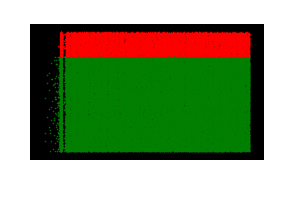

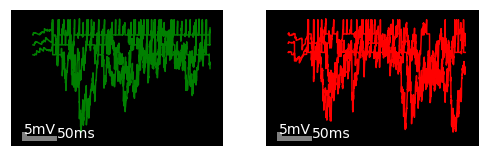

{'fe0': 1.0639758458609181, 'fi0': 1.1129886936423121}


In [98]:
balanced_data = sim.run_sim(Ecell_params, Icell_params, ntwk_params,\
                       syn_params, drive_params,
                       experiment={'type':'recurrent-network'}, tstop=.3, nrec=3)
sim.plot_ntwk_sim(balanced_data)



In [104]:
print(sim.analyze_ntwk_sim(balanced_data))

{'fe0': 61.173116931695972, 'fi0': 48.683614997930803}


In [12]:
## ==========================================
## Compare numerical simulations and analytics
## ==========================================

def compare_analytics_and_sim(analytics_data, sim_data):
    AD, SD = analytics_data, sim_data
    fig, AX = plt.subplots(1, 6, figsize=(6.*3.5,2.5));plt.subplots_adjust(wspace=.4)
    for ax, key, label, scale in zip(AX, ['fe0', 'fi0', 'muV', 'sV', 'DIe', 'DIi'],
                                      ['$\\nu_e$ (Hz)', '$\\nu_i$ (Hz)', '$\mu_V$ (mV)', '$\sigma_V$ (mV)',\
                                          '$I_e$ (pA/ms)', '$I_i$ (pA/ms)'],
                                      [1.,1.,1e3,1e3,1e9,1e9]):
        ax.bar([0], [scale*AD[key]], facecolor='w', edgecolor='k', lw=4, label='analytics') # 1e9 A/s -> pA/ms
        ax.bar([1], [scale*SD[key]], facecolor='lightgray', edgecolor='gray', lw=2, label='simulation')
        set_plot(ax, ylabel=label, xticks=[])
    ax.legend(loc='best', frameon=False, prop={'size':'small'})
    return fig


In [13]:

from graphs.ntwk_dyn_plot import RASTER_PLOT, POP_ACT_PLOT

def plot_ntwk_sim(data):
    
    fig, AX = plt.subplots(1, 2, figsize=(10,3))
    plt.subplots_adjust(left=.25, bottom=.25)
    for i in data['VMS'][0].record:
        AX[0].plot(1e3*data['POP_ACTS'][0].t, 1e3*data['VMS'][0][i].v/brian2.volt+10.*i, 'g-')
        AX[1].plot(1e3*data['POP_ACTS'][0].t, 1e3*data['VMS'][1][i].v/brian2.volt+10.*i, 'r-')
    #plt.plot([50,50], [-30,-10], 'k-', lw=4)
    #plt.annotate('20mV', (60,-7))
    for ax in AX:
        set_plot(ax, ylabel='$V_m$ (mV)', xlabel='time (ms)')

    fig2, ax = RASTER_PLOT([data['RASTERS'][0].t/brian2.second, data['RASTERS'][1].t/brian2.second], [data['RASTERS'][0].i, data['RASTERS'][1].i])
    
# plot_ntwk_sim(data)

In [16]:
A = {'x':np.arange(100), 'y':np.sin(np.arange(100))}
np.savez('temp.npz', **A)

In [19]:
A = np.load('temp.npz')
A['y']

array([ 0.        ,  0.84147098,  0.90929743,  0.14112001, -0.7568025 ,
       -0.95892427, -0.2794155 ,  0.6569866 ,  0.98935825,  0.41211849,
       -0.54402111, -0.99999021, -0.53657292,  0.42016704,  0.99060736,
        0.65028784, -0.28790332, -0.96139749, -0.75098725,  0.14987721,
        0.91294525,  0.83665564, -0.00885131, -0.8462204 , -0.90557836,
       -0.13235175,  0.76255845,  0.95637593,  0.27090579, -0.66363388,
       -0.98803162, -0.40403765,  0.55142668,  0.99991186,  0.52908269,
       -0.42818267, -0.99177885, -0.64353813,  0.29636858,  0.96379539,
        0.74511316, -0.15862267, -0.91652155, -0.83177474,  0.01770193,
        0.85090352,  0.90178835,  0.12357312, -0.76825466, -0.95375265,
       -0.26237485,  0.67022918,  0.98662759,  0.39592515, -0.55878905,
       -0.99975517, -0.521551  ,  0.43616476,  0.99287265,  0.63673801,
       -0.30481062, -0.96611777, -0.7391807 ,  0.1673557 ,  0.92002604,
        0.82682868, -0.02655115, -0.85551998, -0.89792768, -0.11